In [ ]:
import yfinance as yf
import pandas as pd
import time
from datetime import datetime
import matplotlib.pyplot as plt
import squarify
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
from matplotlib.patheffects import withStroke
# Suppress FutureWarnings from yfinance
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from App.repo_utils import omxs30_info

# Step 1: Fetch data
data = []

for symbol in [info["SymbolYahoo"] for info in omxs30_info]:
    try:
        print(f"Fetching data for {symbol}...")
        stock = yf.Ticker(symbol)
        info = stock.info
        
        market_cap = info.get("marketCap", 0)  # Default to 0 if missing
        stock_data = yf.download(symbol, period="5d", interval="1d", progress=False)
        
        if len(stock_data) >= 2:
            stock_data = stock_data.tail(2)
            close_today = stock_data["Close"].iloc[-1]
            close_yesterday = stock_data["Close"].iloc[-2]
            pct_change = float(((close_today - close_yesterday) / close_yesterday) * 100)
        else:
            print(f"Not enough data for {symbol}")
            close_today = close_yesterday = pct_change = None

        data.append({
            "Symbol": symbol,
            "MarketCap": market_cap,
            "CloseToday": close_today,
            "CloseYesterday": close_yesterday,
            "PctChange": pct_change
        })
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")
        data.append({
            "Symbol": symbol,
            "MarketCap": None,
            "CloseToday": None,
            "CloseYesterday": None,
            "PctChange": None
        })

    time.sleep(1)

# Step 2: Create DataFrame and merge
df_pct_change = pd.DataFrame(data)
df_info = pd.DataFrame(omxs30_info)
df_combined = pd.merge(df_info, df_pct_change, left_on="SymbolYahoo", right_on="Symbol", how="left")

# Step 3: Clean and aggregate
df_combined["PctChange"] = pd.to_numeric(df_combined["PctChange"], errors="coerce")
df_combined = df_combined.dropna(subset=["PctChange"])
df_combined["SumMarketCap"] = df_combined["MarketCap"]
df_combined["WeightedDailyChange"] = df_combined["PctChange"]

# Group by BaseSymbol and Sector
df_combined = (
    df_combined
    .groupby(["BaseSymbol", "Sector"], as_index=False)
    .agg({
        "SumMarketCap": "sum",
        "WeightedDailyChange": "mean",
    })
)

# Output final DataFrame
print("Final grouped DataFrame:")
print(df_combined)


Fetching data for ATCO-A.ST...
Fetching data for ATCO-B.ST...
Fetching data for ABB.ST...
Fetching data for AZN.ST...
Fetching data for INVE-B.ST...
Fetching data for VOLV-B.ST...
Fetching data for NDA-SE.ST...
Fetching data for ASSA-B.ST...
Fetching data for SEB-A.ST...
Fetching data for ERIC-B.ST...
Fetching data for HEXA-B.ST...
Fetching data for SWED-A.ST...
Fetching data for SAND.ST...
Fetching data for SHB-A.ST...
Fetching data for HM-B.ST...
Fetching data for ESSITY-B.ST...
Fetching data for ALFA.ST...
Fetching data for EVO.ST...
Fetching data for SAAB-B.ST...
Fetching data for TELIA.ST...
Fetching data for SKF-B.ST...
Fetching data for SCA-B.ST...
Fetching data for BOL.ST...
Fetching data for NIBE-B.ST...
Fetching data for TEL2-B.ST...
Fetching data for GETI-B.ST...
Fetching data for ELUX-B.ST...
Fetching data for KINV-B.ST...
Fetching data for SINCH.ST...
Fetching data for SBB-B.ST...
Final grouped DataFrame:
   BaseSymbol                  Sector   SumMarketCap  WeightedDailyC

In [2]:
# Step 3: Simulate MarketCap and WeightedDailyChange for demonstration purposes
print(df_combined.columns)
df_combined

Index(['BaseSymbol', 'Sector', 'SumMarketCap', 'WeightedDailyChange'], dtype='object')


,BaseSymbol,Sector,SumMarketCap,WeightedDailyChange


## Fixing heatmap size for each company

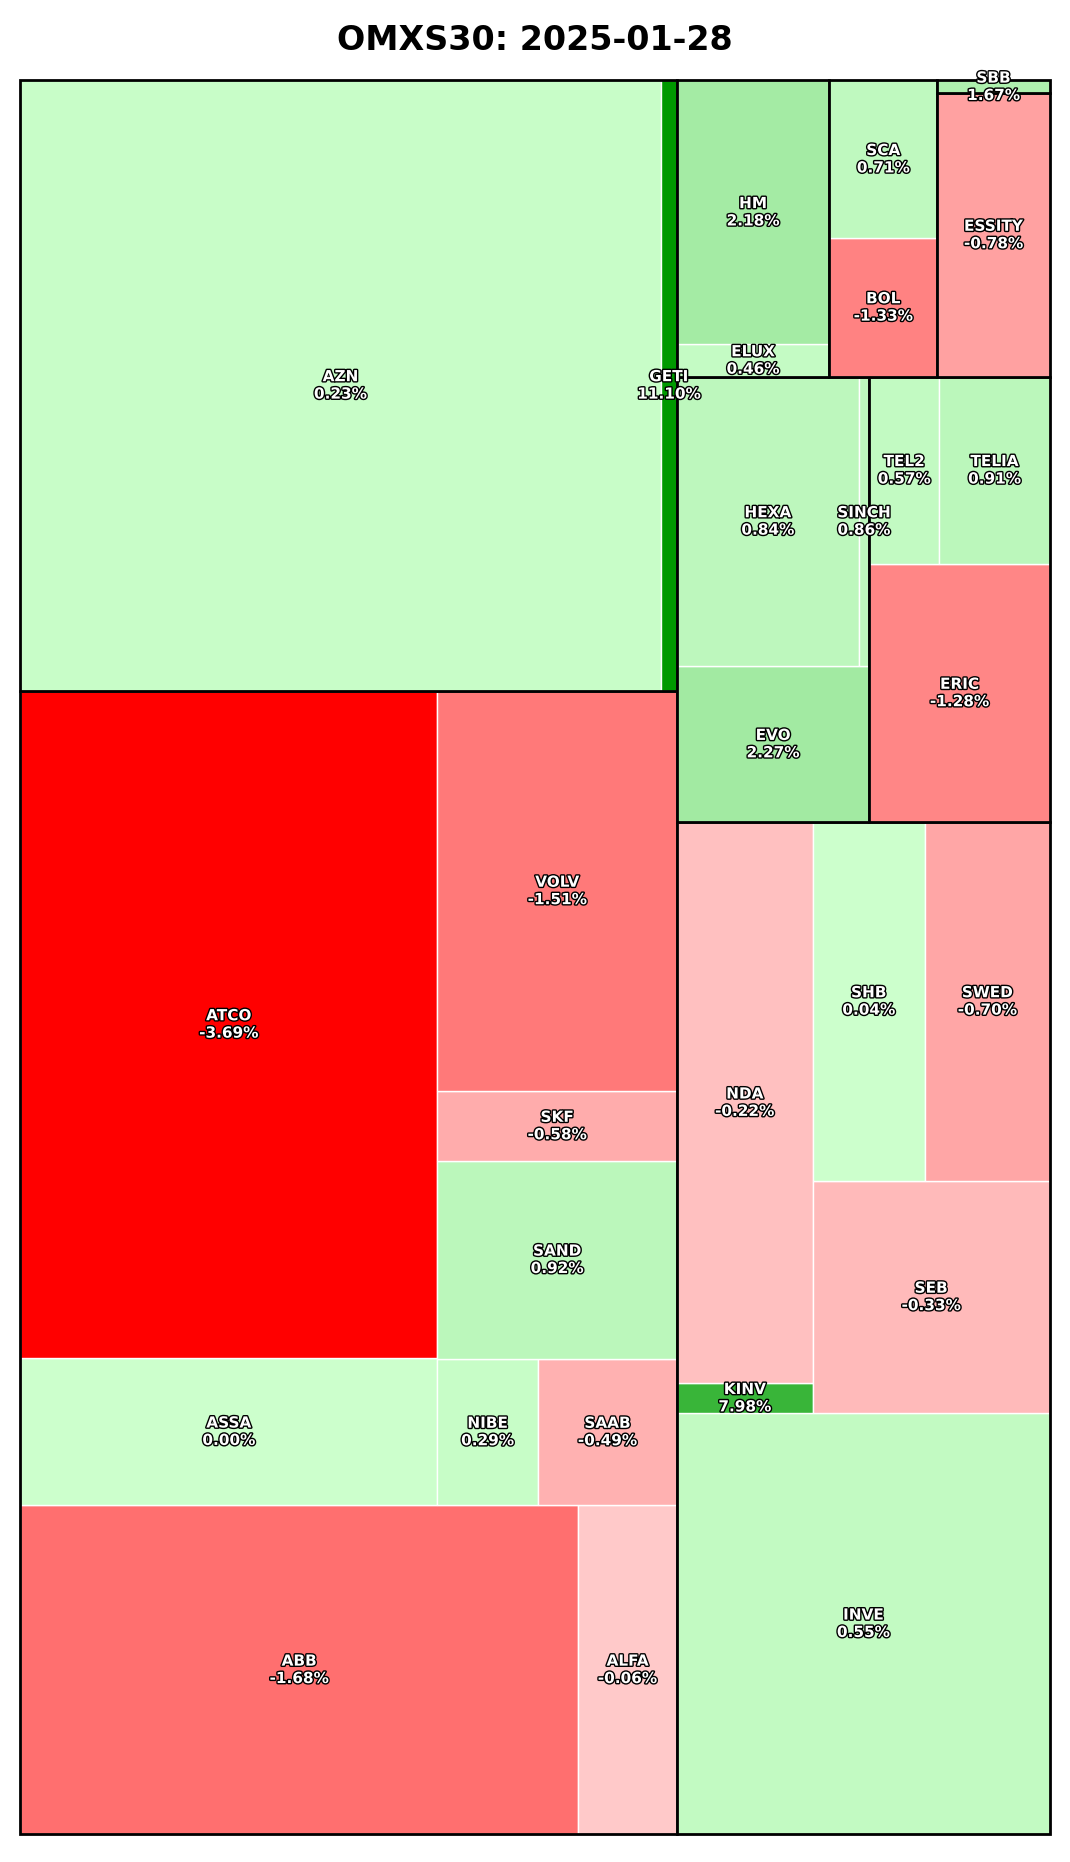

In [5]:
def plot_omxs30_treemap_instagram(df_combined):
    """
    Create a treemap where each company's area is proportional to its market capitalization.
    """
    # Aggregate sector market caps for top-level rectangles
    sector_agg = (
        df_combined
        .groupby("Sector", as_index=False)["SumMarketCap"]
        .sum()
        .rename(columns={"SumMarketCap": "TotalSectorMcap"})
        .sort_values("TotalSectorMcap", ascending=False)
    )

    # Normalize sector sizes to fit within the plot bounds
    total_market_cap = sector_agg["TotalSectorMcap"].sum()
    sector_sizes = sector_agg["TotalSectorMcap"].values / total_market_cap * (100 * 100)
    sector_names = sector_agg["Sector"].values
    sector_rects = squarify.squarify(sector_sizes, 0, 0, 100, 100)

    # Find min and max change for coloring
    min_chg = df_combined["WeightedDailyChange"].min()
    max_chg = df_combined["WeightedDailyChange"].max()

    # Two custom gradients: red-ish for negative, green-ish for positive
    light_red_to_red = LinearSegmentedColormap.from_list(
        "light_red_to_red", ["#FF0000", "#FFCCCC"]
    )
    light_green_to_strong_green = LinearSegmentedColormap.from_list(
        "light_green_to_strong_green", ["#CCFFCC", "#009900"]
    )

    # Normalizers for negative and positive changes
    norm_neg = mcolors.Normalize(vmin=min_chg, vmax=0)
    norm_pos = mcolors.Normalize(vmin=0, vmax=max_chg)

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10.8, 19.2))  # Square figure for balanced treemap

    # Add margins
    margin = 1
    ax.set_xlim(-margin, 100 + margin)
    ax.set_ylim(-margin, 103 + margin)
    ax.axis("off")

    # Main loop: each sector is subdivided into stocks
    for srect, sector_name in zip(sector_rects, sector_names):
        subdf = df_combined[df_combined["Sector"] == sector_name]

        # Normalize company sizes within the sector to fit its allocated area
        sub_total_market_cap = subdf["SumMarketCap"].sum()
        sub_sizes = subdf["SumMarketCap"].values / sub_total_market_cap * (srect["dx"] * srect["dy"])
        sub_rects = squarify.squarify(
            sub_sizes, srect["x"], srect["y"], srect["dx"], srect["dy"]
        )

        # Plot each stock rectangle
        for sbox, row in zip(sub_rects, subdf.itertuples()):
            chg_val = row.WeightedDailyChange
            # Decide which colormap (negative or positive)
            if chg_val >= 0:
                color_rgba = light_green_to_strong_green(norm_pos(chg_val))
            else:
                color_rgba = light_red_to_red(norm_neg(chg_val))

            # Draw rectangle
            ax.add_patch(
                plt.Rectangle(
                    (sbox["x"], sbox["y"]), sbox["dx"], sbox["dy"],
                    facecolor=color_rgba, edgecolor="white"
                )
            )

            # Only add label if area is large enough
            if sbox["dx"] * sbox["dy"] > 2:  # Threshold for small areas
                sym = row.BaseSymbol
                label_str = f"{sym}\n{chg_val:.2f}%" #addign new line for percent
                ax.text(
                    sbox["x"] + sbox["dx"] / 2,
                    sbox["y"] + sbox["dy"] / 2,
                    label_str,
                    ha="center", va="center",
                    fontsize=11, fontweight="bold",
                    color="white",
                    path_effects=[withStroke(linewidth=2, foreground="black")]
                )

        # Draw sector-level bounding box with uniform line width
        ax.add_patch(
            plt.Rectangle(
                (srect["x"], srect["y"]),
                srect["dx"],
                srect["dy"],
                fill=False,
                edgecolor="black",
                linewidth=2
            )
        )

    # Add title and control its position
    fig.suptitle(
        f"OMXS30: {datetime.now().strftime('%Y-%m-%d')}",
        fontsize=24, fontweight="bold", y=0.96  # Use `y` to control vertical position
    )

    # Save and show plot
    plt.tight_layout()
    plt.savefig('OMXS30_HeatMap_daily.png', dpi=800, bbox_inches="tight")
    plt.show()
    
plot_omxs30_treemap_instagram(df_combined)

### Sector heatmap

In [7]:
def plot_omxs30_sector_treemap(df_combined):
    """
    Create a treemap where each sector's area is proportional to its total market capitalization,
    and the label shows the sector name and its average daily percentage change with a custom font.
    """
    import matplotlib.pyplot as plt
    from matplotlib.colors import LinearSegmentedColormap
    from matplotlib.patheffects import withStroke
    import squarify
    import matplotlib.colors as mcolors
    from matplotlib import rcParams
    from datetime import datetime

    # Ensure necessary columns exist
    required_columns = {"Sector", "SumMarketCap", "WeightedDailyChange"}
    if not required_columns.issubset(df_combined.columns):
        raise ValueError(f"Missing required columns: {required_columns - set(df_combined.columns)}")

    # Check for non-empty data
    if df_combined.empty:
        raise ValueError("The provided DataFrame is empty.")

    # Aggregate data by sector
    sector_agg = (
        df_combined
        .groupby("Sector", as_index=False)
        .agg({
            "SumMarketCap": "sum",  # Sum market caps
            "WeightedDailyChange": "mean",  # Average percentage change
        })
        .sort_values("SumMarketCap", ascending=False)
    )

    # Normalize sector sizes to fit within the plot bounds
    total_market_cap = sector_agg["SumMarketCap"].sum()
    if total_market_cap == 0:
        raise ValueError("Total market capitalization is zero. Check the data for correctness.")

    sector_sizes = sector_agg["SumMarketCap"].values / total_market_cap * (100 * 100)
    sector_names = sector_agg["Sector"].values
    sector_changes = sector_agg["WeightedDailyChange"].values
    sector_rects = squarify.squarify(sector_sizes, 0, 0, 100, 100)

    # Shorten sector names for clarity
    short_sector_names = {
        "Consumer Discretionary": "Cons. Disc.",
        "Consumer Staples": "Cons. Stap.",
        "Health Care": "Health",
        "Telecommunications": "Telecom",
        "Basic Materials": "Materials",
        "Financials": "Finance",
        "Industrials": "Industry",
        "Real Estate": "Real Est."
    }
    sector_names_short = [short_sector_names.get(name, name) for name in sector_names]

    # Find min and max change for coloring
    min_chg = sector_agg["WeightedDailyChange"].min()
    max_chg = sector_agg["WeightedDailyChange"].max()

    # Two custom gradients: red-ish for negative, green-ish for positive
    light_red_to_red = LinearSegmentedColormap.from_list(
        "light_red_to_red", ["#FF0000", "#FFCCCC"]
    )
    light_green_to_strong_green = LinearSegmentedColormap.from_list(
        "light_green_to_strong_green", ["#CCFFCC", "#009900"]
    )

    # Normalizers for negative and positive changes
    norm_neg = mcolors.Normalize(vmin=min_chg, vmax=0)
    norm_pos = mcolors.Normalize(vmin=0, vmax=max_chg)

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10.8, 19.2))  # Adjusted size for better layout

    # Add margins
    margin = 1
    ax.set_xlim(-margin, 100 + margin)
    ax.set_ylim(-margin, 103 + margin)
    ax.axis("off")


    # Specify custom font for sector names
    sector_font = "DejaVu Sans" 

    # Plot each sector rectangle
    for srect, sector_name, sector_change in zip(sector_rects, sector_names_short, sector_changes):
        # Decide which colormap (negative or positive)
        if sector_change >= 0:
            color_rgba = light_green_to_strong_green(norm_pos(sector_change))
        else:
            color_rgba = light_red_to_red(norm_neg(sector_change))

        # Draw rectangle with a dark black frame
        ax.add_patch(
            plt.Rectangle(
                (srect["x"], srect["y"]), srect["dx"], srect["dy"],
                facecolor=color_rgba, edgecolor="black", linewidth=2
            )
        )

        # Increase font size for better visibility
        font_size = max(13, min(18, int(srect["dx"] * srect["dy"] ** 0.5 / 40)))

        # Add sector name and average percentage change
        label_str = f"{sector_name}\n{sector_change:.2f}%"
        ax.text(
            srect["x"] + srect["dx"] / 2,
            srect["y"] + srect["dy"] / 2,
            label_str,
            ha="center", va="center",
            fontsize=font_size, fontweight="bold",
            fontname=sector_font,  # Apply custom font
            color="white",
            path_effects=[withStroke(linewidth=2, foreground="black")]
        )

    # Add title and control its position
    fig.suptitle(
        f"OMXS30 Sectors: {datetime.now().strftime('%Y-%m-%d')}",
        fontsize=20, fontweight="bold", y=0.96
    )

    # Save and show plot
    plt.tight_layout()
    plt.savefig('OMXS30_Sector_HeatMap_daily.png', dpi=800, bbox_inches="tight")
    plt.show()

plot_omxs30_sector_treemap(df_combined)


ValueError: The provided DataFrame is empty.